In [29]:
!pip install inference inference-gpu supervision opencv-python
!pip install git+https://github.com/roboflow/sports.git

[notice] A new release of pip is available: 24.0 -> 24.3.1


[notice] To update, run: python.exe -m pip install --upgrade pip

  Running command git clone --filter=blob:none --quiet https://github.com/roboflow/sports.git 'C:\Users\isss1\AppData\Local\Temp\pip-req-build-oo91e4za'

  Cloning https://github.com/roboflow/sports.git to c:\users\isss1\appdata\local\temp\pip-req-build-oo91e4za


[notice] A new release of pip is available: 24.0 -> 24.3.1


  Resolved https://github.com/roboflow/sports.git to commit 06053616f1f8a8ae1fa936eb00dcdc2e4f888bb1

[notice] To update, run: python.exe -m pip install --upgrade pip


  Preparing metadata (setup.py): started


  Preparing metadata (setup.py): finished with status 'done'

In [2]:
!pip install torch


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import torch

if torch.cuda.is_available():
    print("CUDA is available. Training on GPU!")
else:
    print("CUDA is not available. Training on CPU.")

CUDA is not available. Training on CPU.


[10/29/24 19:36:15] WARNING  Your inference package version 0.23.0 is out of date! Please upgrade to ]8;id=622142;file://c:\Users\isss1\GitHub\soccer-computer-vision-analysis\soccer-env\Lib\site-packages\inference\core\__init__.py\__init__.py]8;;\:]8;id=795274;file://c:\Users\isss1\GitHub\soccer-computer-vision-analysis\soccer-env\Lib\site-packages\inference\core\__init__.py#41\41]8;;\
                             version 0.24.0 of inference for the latest features and bug fixes by                  
                             running `pip install --upgrade inference`.                                            

SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Detections(xyxy=array([[1195.,  367., 1238.,  459.],
       [  60.,  526.,  122.,  647.],
       [1656.,  580., 1726.,  701.],
       [1503.,  426., 1555.,  527.],
       [1095.,  461., 1138.,  566.],
       [ 857.,  439.,  914.,  535.],
       [ 756.,  382.,  803.,  481.],
       [ 850.,  344.,  891.,  427.],
       [ 800.,  317.,  843.,  387.],
       [1150.,  349., 1178.,  426.],
       [ 370.,  404.,  409.,  510.],
       [1321.,  412., 1350.,  505.],
       [1183.,  313., 1214.,  384.],
       [1459.,  389., 1501.,  483.],
       [1315.,  347., 1339.,  416.],
       [1045.,  419., 1081.,  478.],
       [1642.,  428., 1672.,  534.],
       [1051.,  365., 1072.,  433.],
       [ 747.,  420.,  770.,  442.]]), mask=None, confidence=array([0.93859369, 0.9361639 , 0.93506873, 0.92912686, 0.92835104,
       0.92403758, 0.92248756, 0.9132008 , 0.90408027, 0.89720261,
       0.89320207, 0.89172792, 0.88695693, 0.8834542 , 0.86871785,
       0.8426497 , 0.84187245, 0.79695284, 0.60329545]),

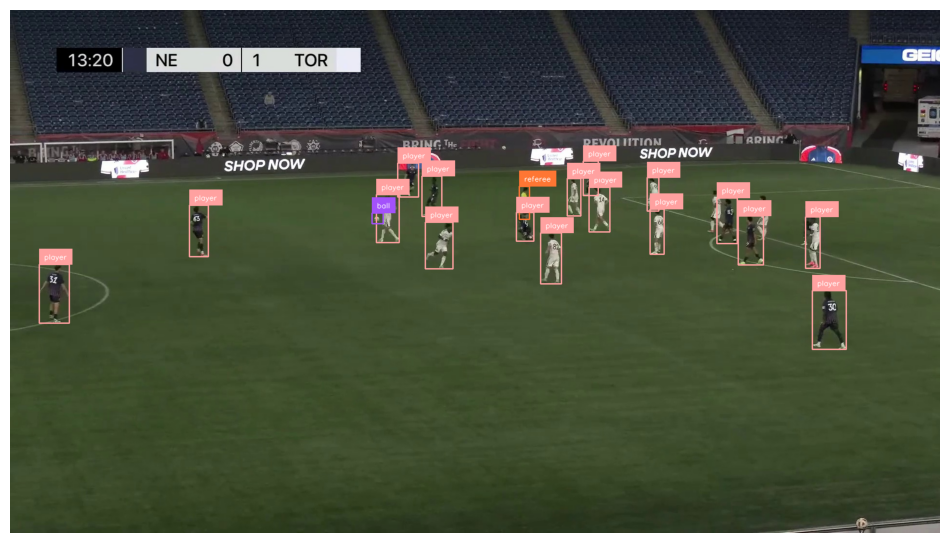

In [4]:
from inference import get_model
import supervision as sv
import cv2

# define the image url to use for inference
image_file = "images-object/frame600.jpg"
image = cv2.imread(image_file)

# load a pre-trained yolov8n model
objectModel = get_model(model_id="soccer-computer-vision-acffy/3")

# run inference on our chosen image, image can be a url, a numpy array, a PIL image, etc.

results = objectModel.infer(image)[0]

# load the results into the supervision Detections api
detections = sv.Detections.from_inference(results)

# create supervision annotators
bounding_box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

# annotate the image with our inference results
print(detections)

annotated_image = bounding_box_annotator.annotate(scene=image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

# display the image
sv.plot_image(annotated_image)

In [35]:
import supervision as sv
from inference import get_model
import numpy as np

PITCH_CONFIDENCE_LEVEL = 0.7
KEYPOINT_CONFIDENCE_LEVEL = 0.6
OBJECT_DETECTION_MODEL_NAME = "soccer-computer-vision-acffy/3"
KEYPOINT_DETECTION_MODEL_NAME = "football-field-detection-f07vi/15"

def getObjectDetections(frame, index):
    objectModel = get_model(model_id=OBJECT_DETECTION_MODEL_NAME)
    result = objectModel.infer(frame, confidence=0.3)[0]
    detections = sv.Detections.from_inference(result)

    return detections

# Uses a keypoint detection model to return pitch keypoints
def getPitchKeypoints(image):
    keypointModel = get_model(model_id=KEYPOINT_DETECTION_MODEL_NAME)
    result = keypointModel.infer(image, confidence=PITCH_CONFIDENCE_LEVEL)[0]    
    keypoints = sv.KeyPoints.from_inference(result)
    
    return keypoints

def getKeypointsFilter(keypoints):
    filter = keypoints.confidence > KEYPOINT_CONFIDENCE_LEVEL
    
    return filter
    
def getFilteredKeypoints(keypoints, filter):
    xy = keypoints.xy[filter]
    confidence = keypoints.confidence[filter]
    filteredKeypoints = sv.KeyPoints(xy=xy[np.newaxis, ...], confidence=confidence[np.newaxis, ...])
    
    return filteredKeypoints

class ViewTransformer:
    def __init__(self, source: np.ndarray, target: np.ndarray) -> None:
        if source.shape != target.shape:
            raise ValueError(
                "Source and target must have the same shape.")
        if source.shape[1] != 2:
            raise ValueError(
                f"Source and target points must be 2D coordinates. They are currently {source.shape} and {target.shape}.")

        source = source.astype(np.float32)
        target = target.astype(np.float32)

        self.m, _ = cv2.findHomography(source, target)
        if self.m is None:
            raise ValueError(
                "Homography matrix could not be calculated.")

    def transformPoints(self, points: np.ndarray) -> np.ndarray:
        if points.size == 0:
            return points

        if points.shape[1] != 2:
            raise ValueError("Points must be 2D coordinates.")

        points = points.reshape(-1, 1, 2).astype(np.float32)
        points = cv2.perspectiveTransform(points, self.m)
        
        return points.reshape(-1, 2).astype(np.float32)

Detection Counts
Ball: 1
Goalkeepers: 0
Players: 17
Referees: 0
Pre-transformed
[[1334.   558.5]
 [ 489.   596. ]
 [1460.5  438.5]
 [1388.5  477.5]
 [1221.5  468. ]
 [ 913.   465.5]
 [1491.   306. ]
 [ 538.   428. ]
 [1260.5  438.5]
 [ 813.5  397. ]
 [1323.5  383.5]
 [1809.   543.5]
 [1019.   332.5]
 [1815.5  348.5]
 [ 970.   286.5]
 [ 582.   292.5]
 [ 491.5  286.5]]
After Transformation
[[7099.8955  3973.517  ]
 [5347.062   4157.206  ]
 [7633.1787  2620.6821 ]
 [7368.3667  3102.953  ]
 [6994.775   2945.2314 ]
 [6264.9497  2837.552  ]
 [8163.875    391.16068]
 [5338.4883  2230.1816 ]
 [7141.0107  2568.8743 ]
 [6045.3438  1837.2305 ]
 [7424.885   1768.4216 ]
 [8131.2095  3924.8425 ]
 [6673.0493   767.7725 ]
 [8910.883   1322.1221 ]
 [6588.2583  -228.09882]
 [5341.882   -233.5997 ]
 [5041.8115  -407.7377 ]]


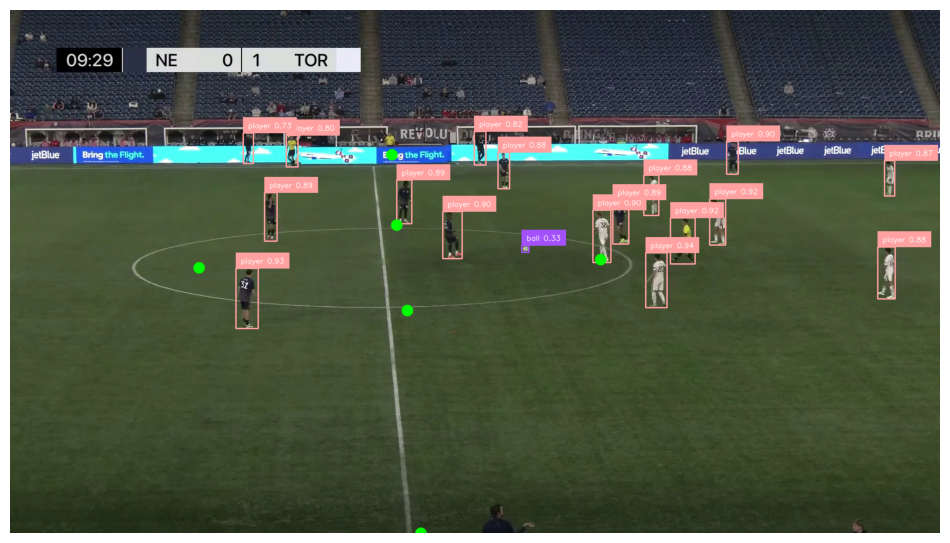

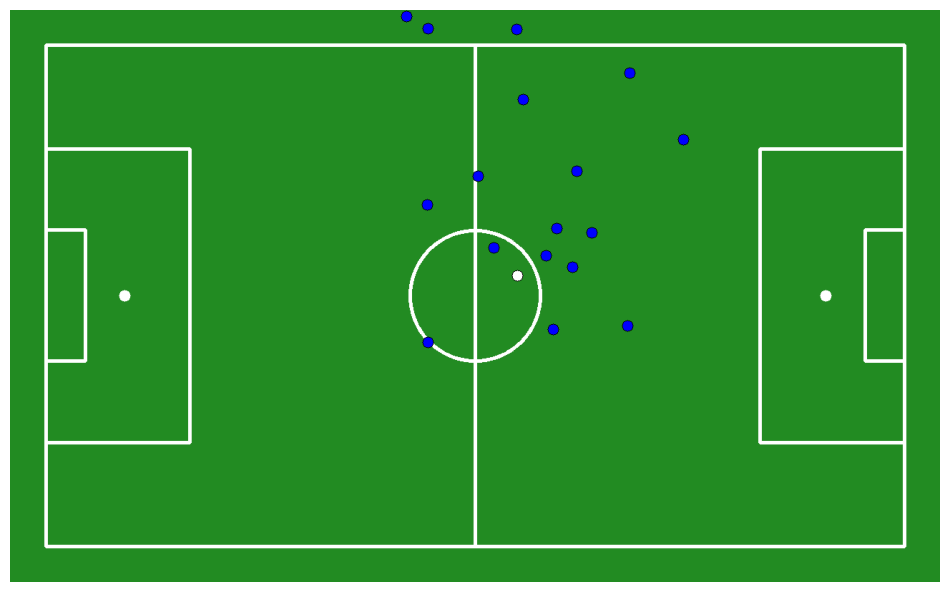

In [43]:
from sports.configs.soccer import SoccerPitchConfiguration
from sports.annotators.soccer import draw_pitch, draw_points_on_pitch

SOCCER_PITCH_CONFIG = SoccerPitchConfiguration()

# Perspective transformation
fileName = "images-pitch/frame35.jpg"
image = cv2.imread(fileName)
keypoints = getPitchKeypoints(image)
filter = getKeypointsFilter(keypoints)

filteredKeypoints = getFilteredKeypoints(keypoints, filter)
objectDetections = getObjectDetections(image, None)

# Added this in as the pitch configuration only has 32 keypoints
targetKeypoints = np.array(SOCCER_PITCH_CONFIG.vertices)[filter[0]]


sourceXy = filteredKeypoints.xy[0].astype(np.float32)
targetXy = targetKeypoints.astype(np.float32)

# Will need to adjust my keypoints mapping to conform with this
transformer = ViewTransformer(
    source=sourceXy,
    target=targetXy
)

BALL_CLASS_ID = 0
GOALKEEPER_CLASS_ID = 1
PLAYER_CLASS_ID = 2
REFEREE_CLASS_ID = 3

# Obtain class separated detections to denote them differently by colour
ballDetections = objectDetections[objectDetections.class_id == BALL_CLASS_ID]
goalkeeperDetections = objectDetections[objectDetections.class_id == GOALKEEPER_CLASS_ID]
playerDetections = objectDetections[objectDetections.class_id == PLAYER_CLASS_ID]
refereeDetections = objectDetections[objectDetections.class_id == REFEREE_CLASS_ID]

# Transforming detections for the homography matrix
ballCoords = transformer.transformPoints(points=ballDetections.get_anchors_coordinates(anchor=sv.Position.CENTER))
goalkeeperCoords = transformer.transformPoints(points=goalkeeperDetections.get_anchors_coordinates(anchor=sv.Position.CENTER))
playerCoords = transformer.transformPoints(points=playerDetections.get_anchors_coordinates(anchor=sv.Position.CENTER))
refereeCoords = transformer.transformPoints(points=refereeDetections.get_anchors_coordinates(anchor=sv.Position.CENTER))

print(playerDetections.get_anchors_coordinates(anchor=sv.Position.CENTER))

# Output detections image, with keypoints and object detection
boundingBoxAnnotator = sv.BoxAnnotator()
labelAnnotator = sv.LabelAnnotator()
keypointAnnotator = sv.VertexAnnotator(radius=12, color=sv.Color.GREEN)
keypoint2Annotator = sv.VertexAnnotator(radius=12, color=sv.Color.RED)
lineAnnotator = sv.EdgeAnnotator(color=sv.Color.RED, thickness=2, edges=SOCCER_PITCH_CONFIG.edges)
    
objectLabels = [ f"{class_name} {confidence:.2f}" for class_name, confidence in zip(objectDetections['class_name'], objectDetections.confidence) ]


# annotate the image with our inference results
# Must use all 32 points for the edge annotator, according to the API
footageImage = boundingBoxAnnotator.annotate(scene=image, detections=objectDetections)
footageImage = labelAnnotator.annotate(scene=footageImage, detections=objectDetections, labels=objectLabels)

# Plotting all available keypoints, but showing their confidence levels
footageImage = keypointAnnotator.annotate(footageImage, filteredKeypoints)

sv.plot_image(footageImage)

pitchImage = draw_pitch(SOCCER_PITCH_CONFIG)

annotatedPitch = draw_points_on_pitch(
    config=SOCCER_PITCH_CONFIG,
    xy=ballCoords,
    face_color=sv.Color.WHITE,
    edge_color=sv.Color.BLACK,
    radius=8,
    thickness=1,
    pitch=pitchImage
)

annotatedPitch = draw_points_on_pitch(
    config=SOCCER_PITCH_CONFIG,
    xy=goalkeeperCoords,
    face_color=sv.Color.GREEN,
    edge_color=sv.Color.BLACK,
    radius=8,
    thickness=1,
    pitch=annotatedPitch
)

annotatedPitch = draw_points_on_pitch(
    config=SOCCER_PITCH_CONFIG,
    xy=playerCoords,
    face_color=sv.Color.BLUE,
    edge_color=sv.Color.BLACK,
    radius=8,
    thickness=1,
    pitch=annotatedPitch
)

annotatedPitch = draw_points_on_pitch(
    config=SOCCER_PITCH_CONFIG,
    xy=refereeCoords,
    face_color=sv.Color.YELLOW,
    edge_color=sv.Color.BLACK,
    radius=8,
    thickness=1,
    pitch=annotatedPitch
)

sv.plot_image(annotatedPitch)